MODEL TO RECOMMEND PLAYER ACTIONS IN BLACKJACK

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report , roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("blackjack_simulator.csv")

#trimming dataset by 60% , dataset is 50million blackjack hands.
df = df.sample(frac=0.4,random_state = 42).reset_index(drop=True)

df.head

<bound method NDFrame.head of           shoe_id  cards_remaining  dealer_up initial_hand   dealer_final  \
0          410016              416          6      [5, 10]    [6, 10, 10]   
1           79893              162          7      [2, 11]  [7, 5, 4, 10]   
2          127301              219          8      [10, 5]     [8, 7, 10]   
3          766383              236          7      [10, 3]        [7, 10]   
4          642786              144          2      [4, 10]  [2, 2, 8, 10]   
...           ...              ...        ...          ...            ...   
19999995    26657              219          4       [7, 8]  [4, 2, 7, 10]   
19999996   615259              290         10       [2, 4]       [10, 10]   
19999997   564659              205          9       [4, 9]        [9, 10]   
19999998    20826              222         10      [2, 10]     [10, 6, 2]   
19999999   659399              390          6      [10, 7]      [6, 7, 5]   

         dealer_final_value      player_final

Data Exploration - Understanding the dataset

Also to satisfy my own curiosity on common blackjack strategy myths lol

House Edge

In [2]:
win_mean = df.win.mean()

print(f'Expected Value: {win_mean:%}')

Expected Value: -0.577882%


This is quite unexpected , its commonly known that the house has on average 2% edge over the player in most casinos. 51/49 is usually the expected dealer/player split.

How many blackjacks does the player get on average?

In [3]:
bj_rate_all = df[df.player_final_value == "['BJ']"].shape[0] / df.shape[0]
print(f'Blackjack Rate: {bj_rate_all:%}')

Blackjack Rate: 4.747410%


This is quite expected. On average , 2% of hands will result in a blackjack, and as the number of shoe increases , the rate of blackjack increases proportionately. 4.74% is still a low % chance , considering that the only way to profit off blackjack is to leverage off blackjacks as it is a 1.5x payout. rigged game? lol

Counting Cards - Does it work?

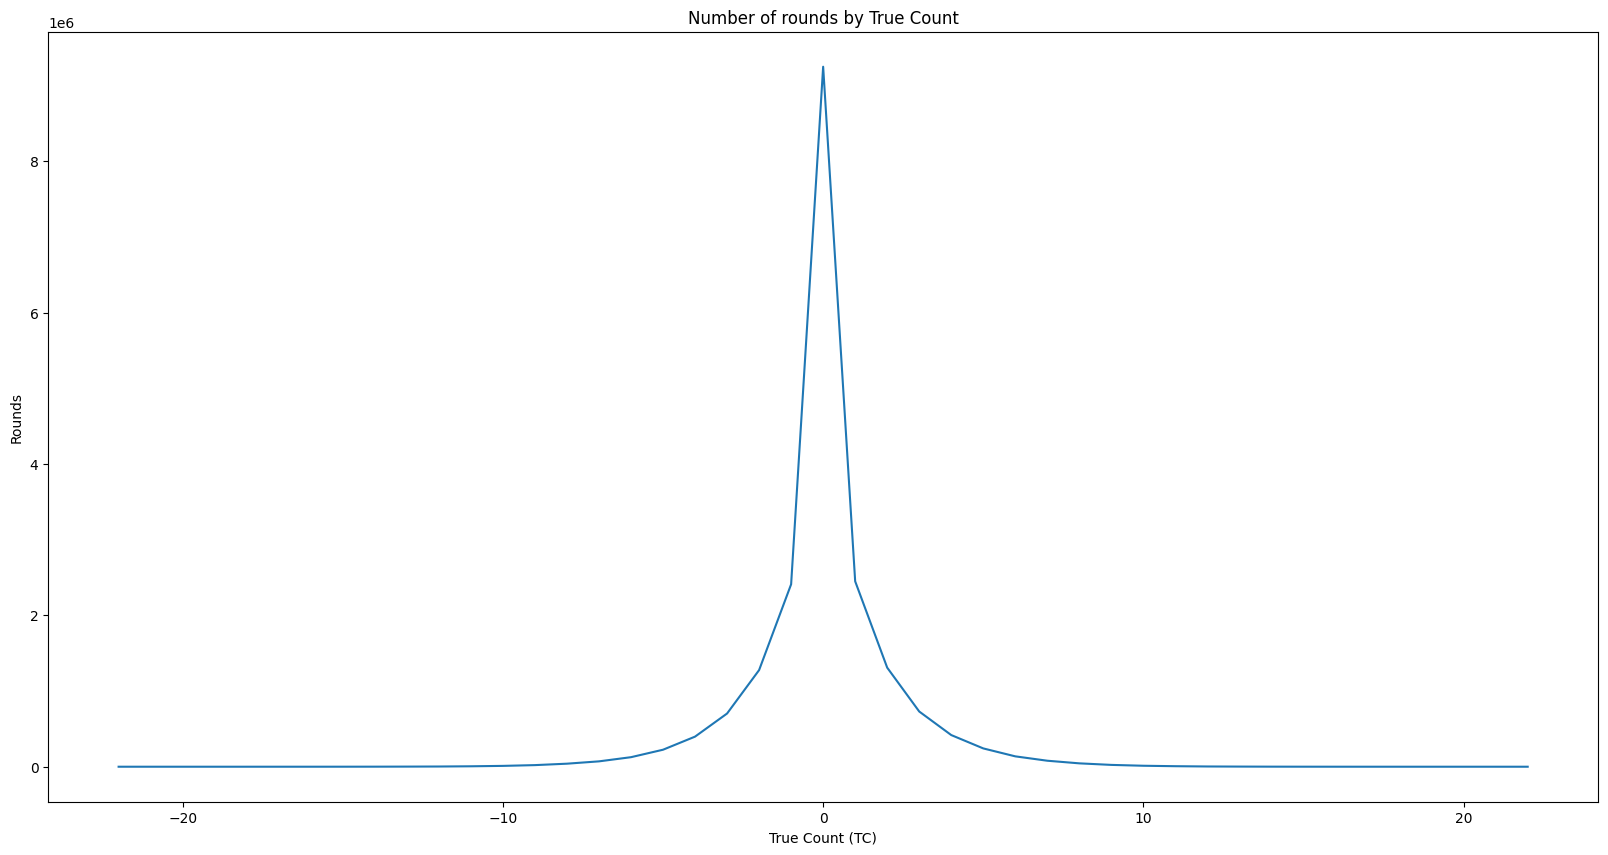

In [4]:
import matplotlib.pyplot as plt

true_counts = df.true_count.value_counts().sort_index()

plt.figure(figsize=(20, 10))
plt.title('Number of rounds by True Count')
plt.xlabel('True Count (TC)')
plt.ylabel('Rounds')
plt.plot(true_counts)
plt.show()

We're able to see that the TC has a standard distribution around 0. This is expected in a standard casino 6 deck setting.

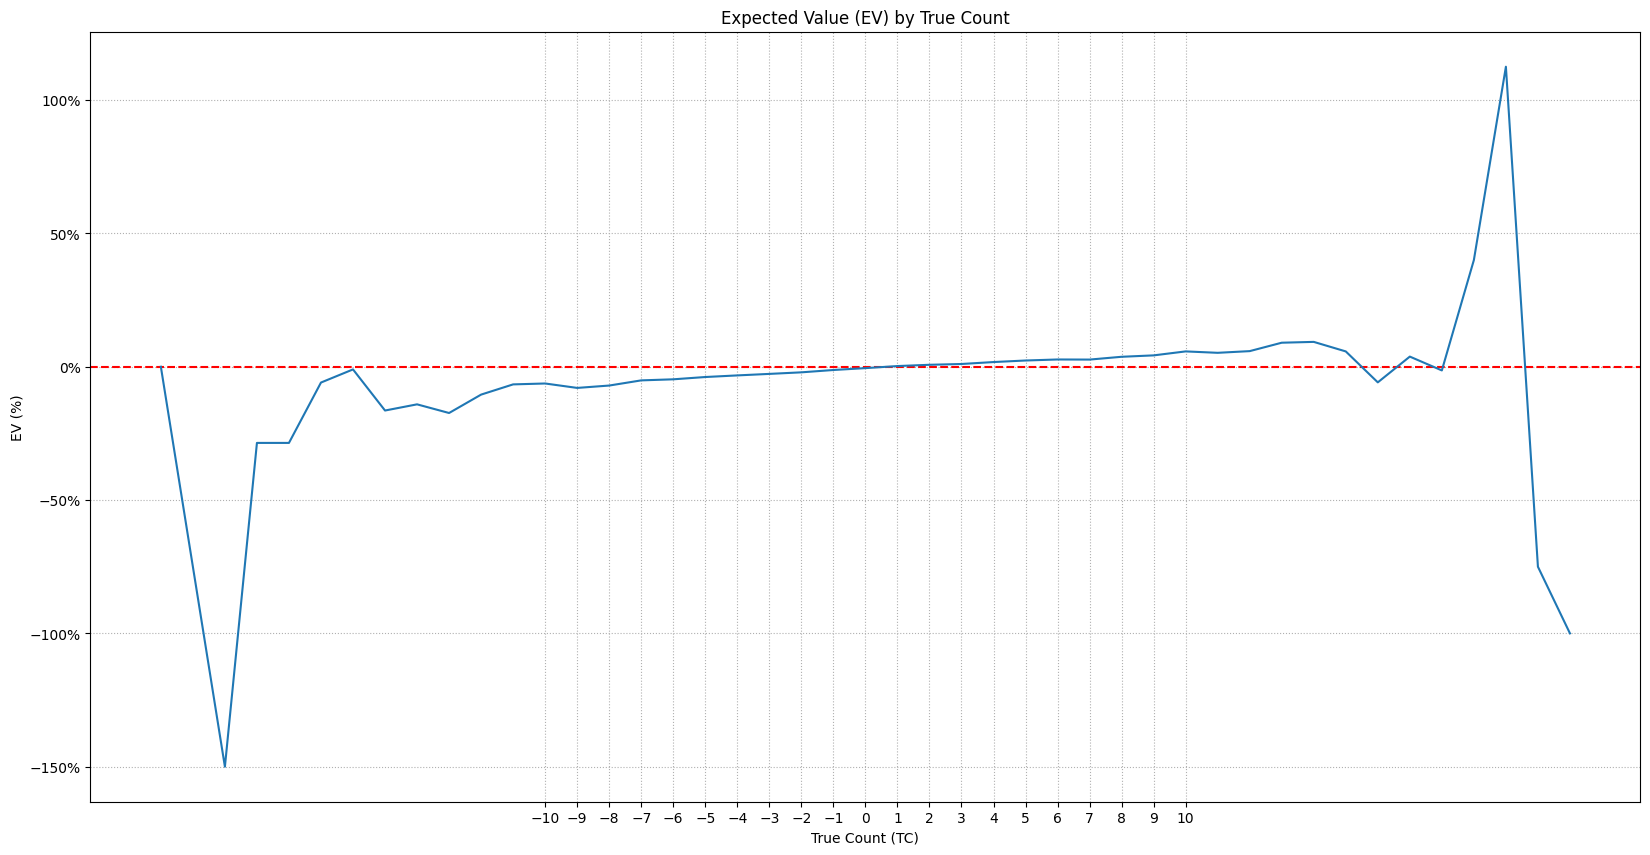

In [5]:
from matplotlib.ticker import PercentFormatter
ev_by_count_full = df.loc[:, ['true_count', 'win']].groupby('true_count').mean()

plt.figure(figsize=(20, 10))
plt.title('Expected Value (EV) by True Count')
plt.xlabel('True Count (TC)')
plt.ylabel('EV (%)')
plt.grid(axis='both', linestyle=':')
plt.xticks(range(-10, 11, 1))
plt.axhline(y=0, color='r', linestyle='--')
plt.plot(ev_by_count_full)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

outliers beyond -10 TC and 10 TC. This is quite expected. It is really difficult for a shoe to reach a true count of anything above 10 or below -10.

Removing noise in outliers

In [6]:
df = df[df['true_count'].between(-10, 10)]

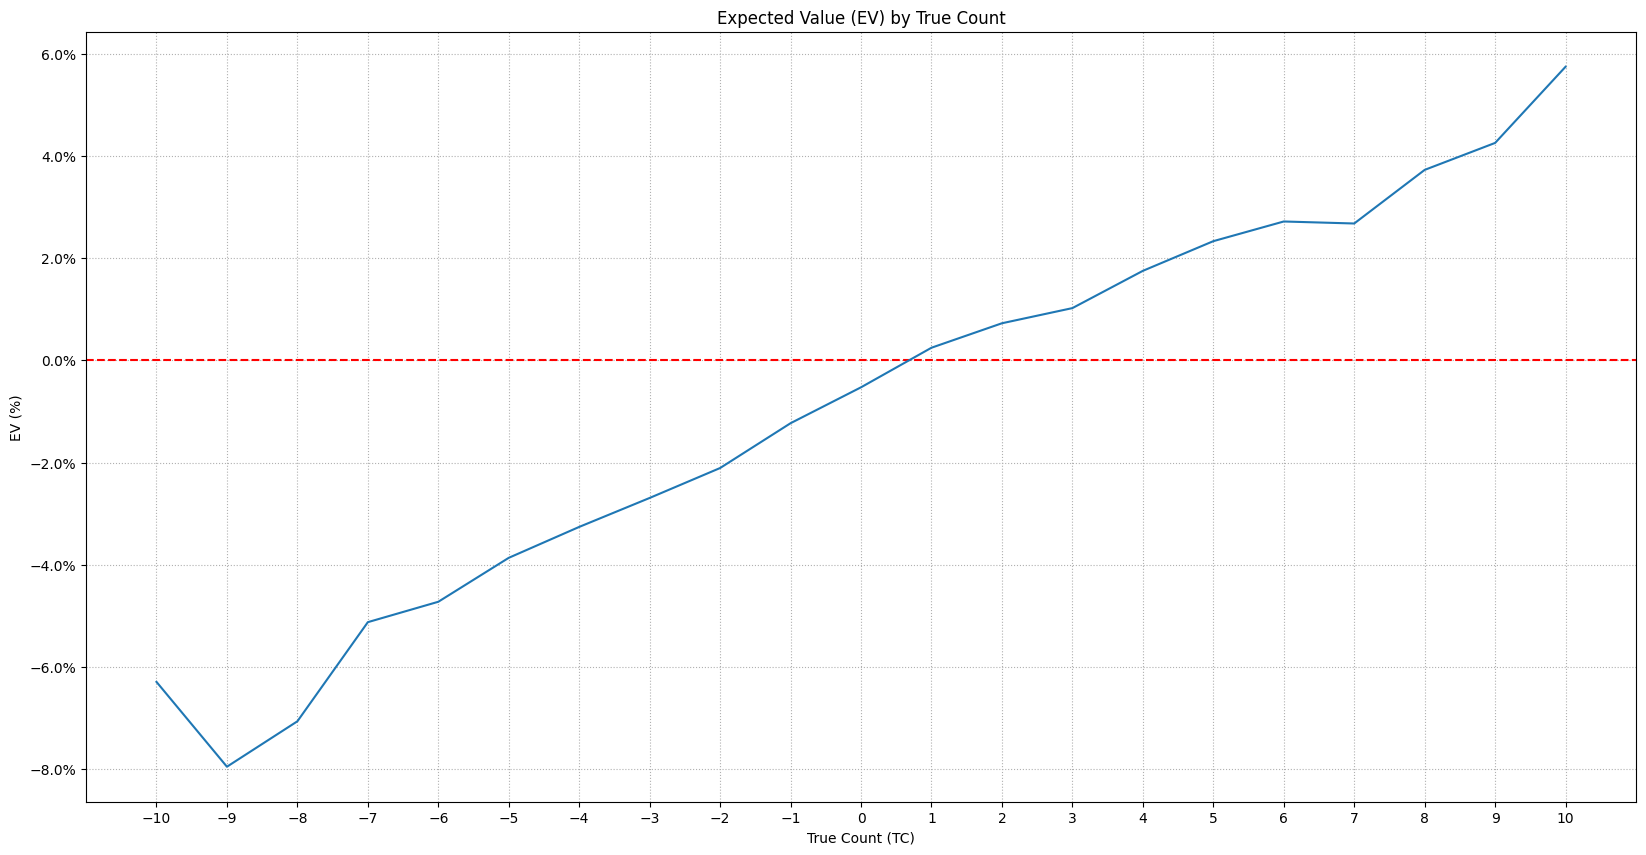

In [7]:

ev_by_count = df.loc[:, ['true_count', 'win']].groupby('true_count').mean()

plt.figure(figsize=(20, 10))
plt.title('Expected Value (EV) by True Count')
plt.xlabel('True Count (TC)')
plt.ylabel('EV (%)')
plt.grid(axis='both', linestyle=':')
plt.xticks(range(-10, 11, 1))
plt.axhline(y=0, color='r', linestyle='--')
plt.plot(ev_by_count)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Higher counts = Higher EV%
Higher Counts in shoe = Better for player
Equilibrium of EV 0% lies at TC 0.6-ish, which means that when TC is above 0.6 , we should bet more. When TC is below 0.6, we should bet less.

How often does dealer bust relative to True Count?

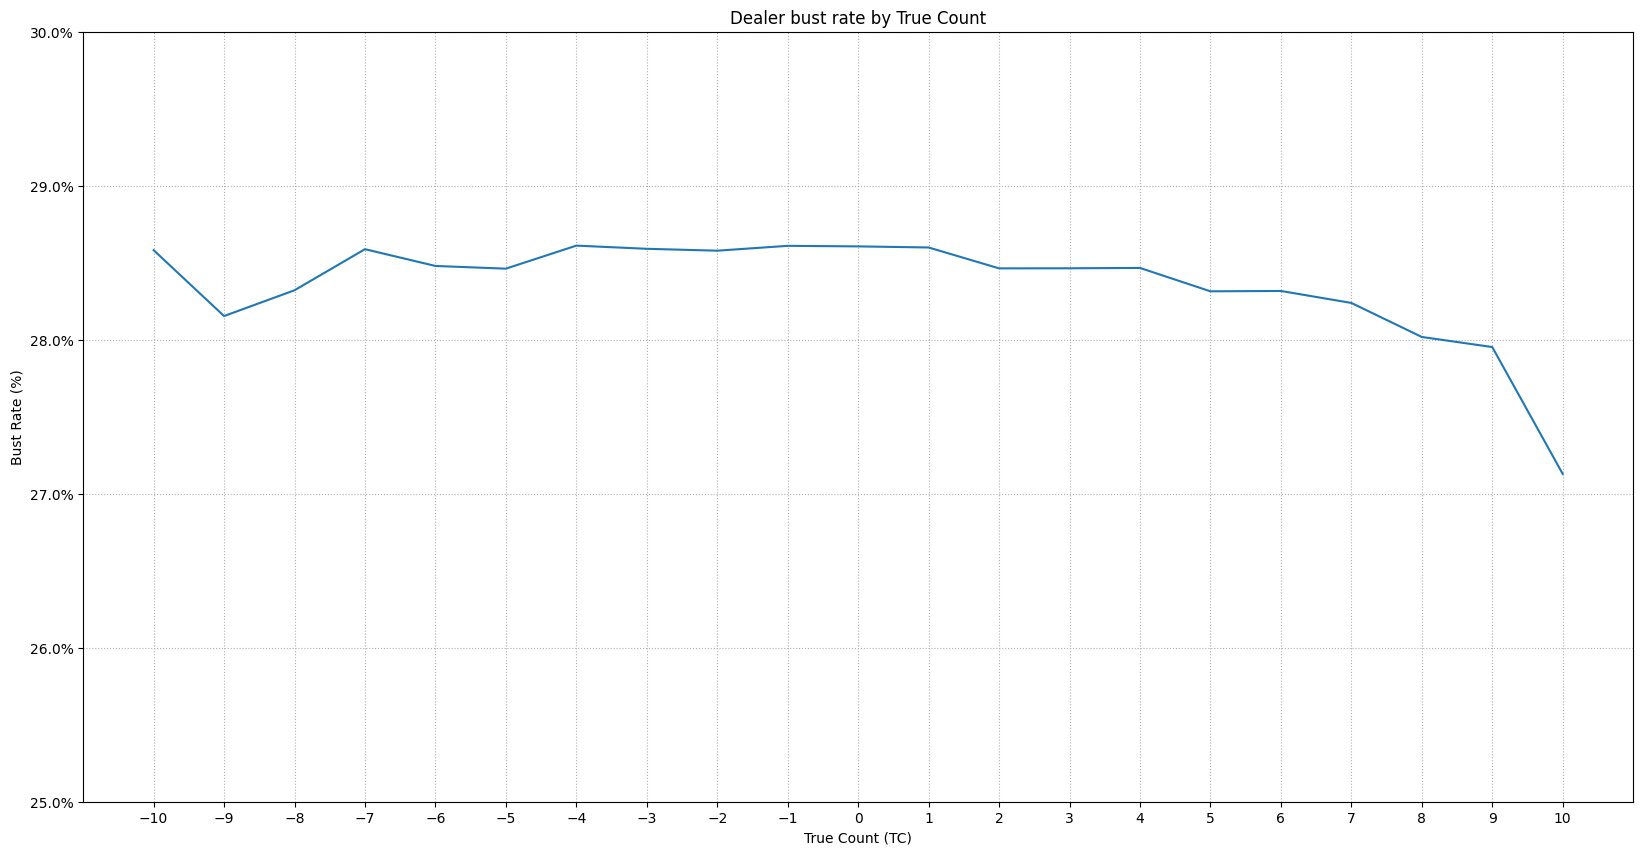

In [8]:
dealer_final_numeric = pd.to_numeric(df.dealer_final_value, errors='coerce')
busts = pd.concat([df.true_count, dealer_final_numeric > 21], keys=['true_count', 'bust'], axis=1)
pct_bust = (busts[busts.bust == True].groupby(['true_count']).count() / busts.groupby(['true_count']).count()).reset_index()

plt.figure(figsize=(20, 10))
plt.plot(pct_bust.true_count, pct_bust.bust)
plt.title('Dealer bust rate by True Count')
plt.xlabel('True Count (TC)')
plt.ylabel('Bust Rate (%)')
plt.grid(axis='both', linestyle=':')
plt.ylim(ymin=0.25, ymax=0.3)
plt.xticks(range(-10, 11, 1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

The dealer busts on average , 28% of the time when TC is between -10 and 4. Above TC of 4, the dealer is LESS likely to bust.. wait what ?! 

Does higher TC = more blackjacks?
spoiler : yes duh but we let the data prove itself

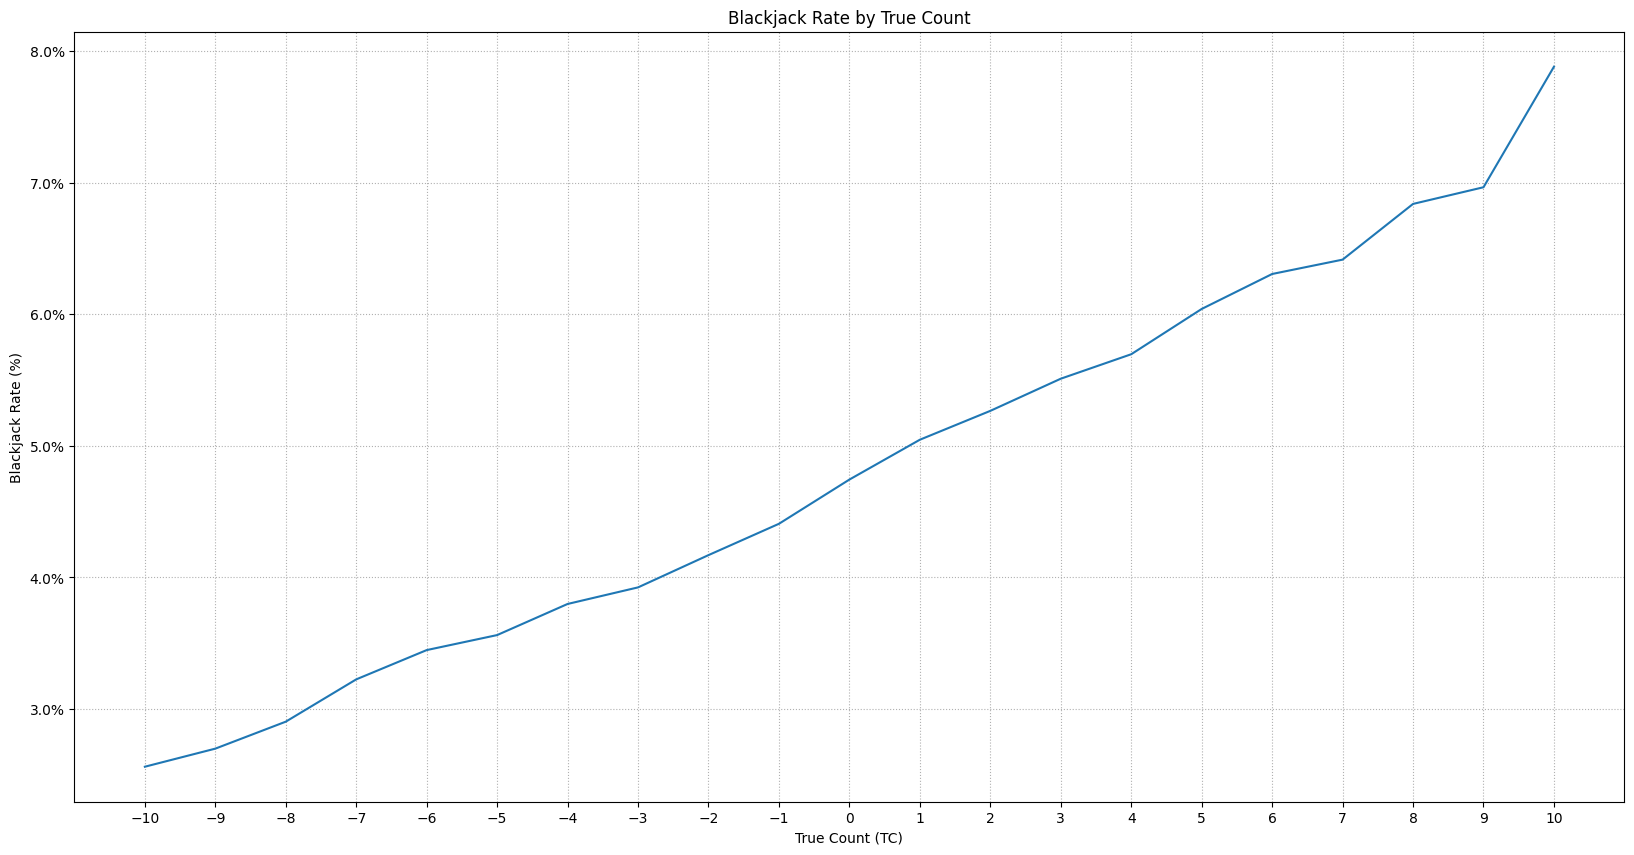

In [9]:
player_bjs = pd.concat([df.true_count, df.player_final_value == "['BJ']"], keys=['true_count', 'player_bj'], axis=1)
player_bj_rate = (player_bjs[player_bjs.player_bj == True].groupby(['true_count']).count() / player_bjs.groupby(['true_count']).count()).reset_index()

plt.figure(figsize=(20, 10))
plt.plot(player_bj_rate.true_count, player_bj_rate.player_bj)
plt.title('Blackjack Rate by True Count')
plt.xlabel('True Count (TC)')
plt.ylabel('Blackjack Rate (%)')
plt.grid(axis='both', linestyle=':')
plt.xticks(range(-10, 11, 1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

How much will getting a Blackjack affect your winnings per TC?

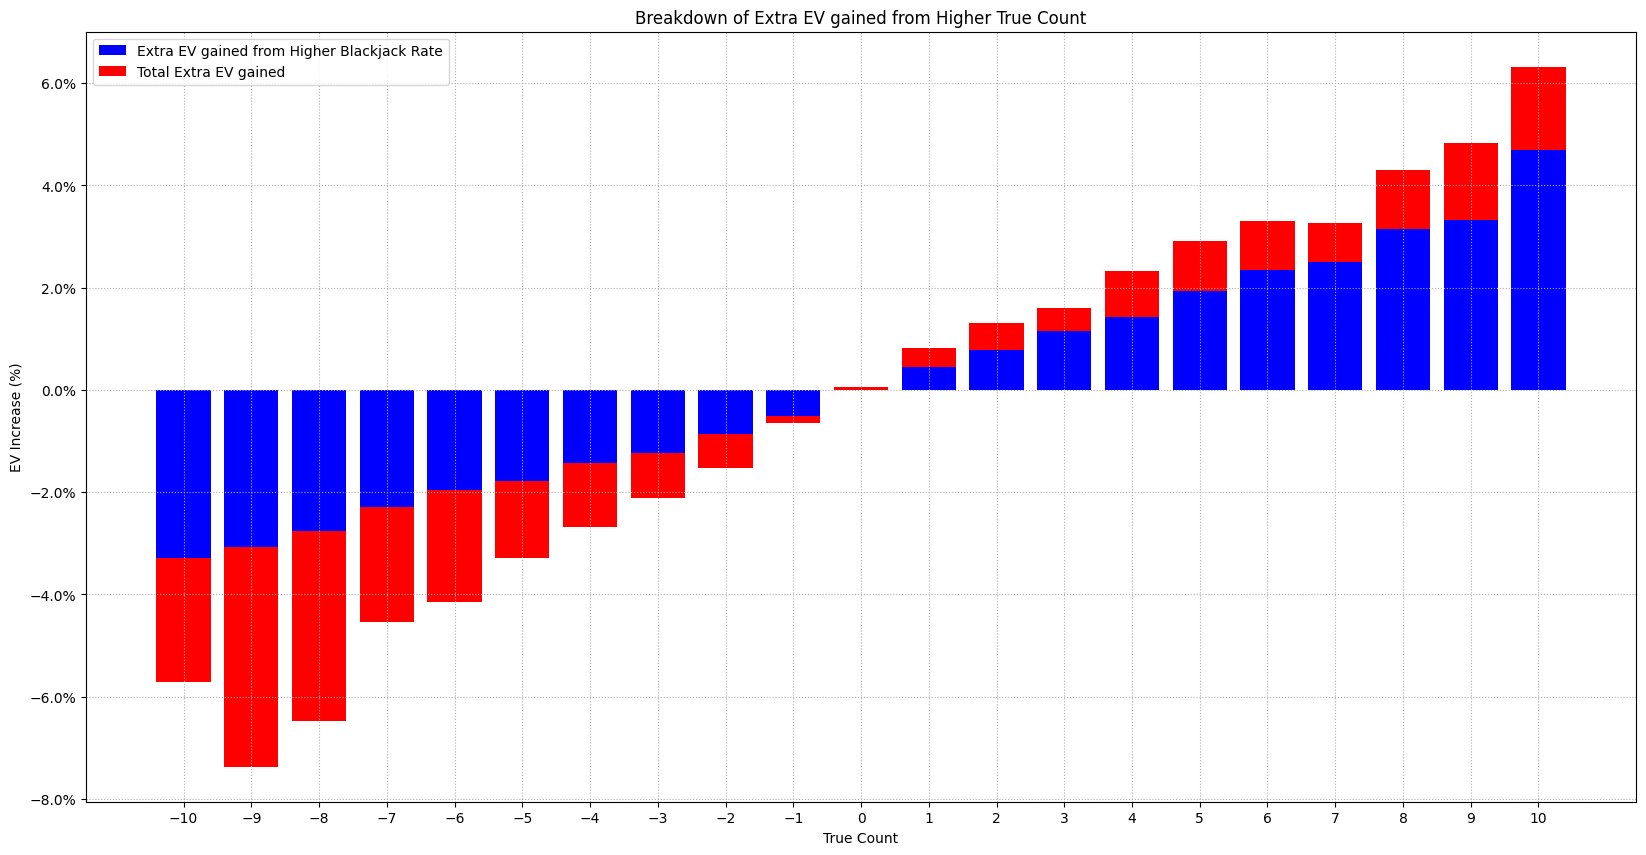

In [10]:
player_bj_rate_increase = player_bj_rate.player_bj - bj_rate_all
player_bj_ev_increase = player_bj_rate_increase * 1.5  
player_bj_ev_increase.index = ev_by_count.index
ev_increase = ev_by_count.win - win_mean

plt.figure(figsize=(20, 10))
plt.bar(player_bj_rate.true_count, player_bj_ev_increase, color='b')
plt.bar(player_bj_rate.true_count, ev_increase - player_bj_ev_increase, color='r', bottom=player_bj_ev_increase)
plt.title('Breakdown of Extra EV gained from Higher True Count')
plt.xlabel('True Count')
plt.ylabel('EV Increase (%)')
plt.grid(axis='both', linestyle=':')
plt.xticks(range(-10, 11, 1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(['Extra EV gained from Higher Blackjack Rate', 'Total Extra EV gained'])
plt.show()

As TC gets higher , chances of Blackjack increase, and majority of the extra earnings from a player in a shoe of high TC comes from hitting Blackjacks. (ie. betting more and leveraging on a high true count hoping to hit a blackjack.)

Data Preprocessing

Checking for null values

In [11]:
df.isnull().sum()

shoe_id               0
cards_remaining       0
dealer_up             0
initial_hand          0
dealer_final          0
dealer_final_value    0
player_final          0
player_final_value    0
actions_taken         0
run_count             0
true_count            0
win                   0
dtype: int64

Feature Extraction Functions

In [12]:
print(type(df['initial_hand'].iloc[0]))  

<class 'str'>


In [13]:
import ast


df['initial_hand'] = df['initial_hand'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['actions_taken'] = df['actions_taken'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [14]:
def feature_engineering(df):
    df['card1'] = df['initial_hand'].apply(lambda x: x[0])
    df['card2'] = df['initial_hand'].apply(lambda x: x[1])
    
    df['is_pair'] = df.apply(lambda row: 1 if row['card1'] == row['card2'] else 0, axis=1)
    df['has_ace'] = df['initial_hand'].apply(lambda x: 1 if 11 in x else 0)
    df['hand_sum'] = df['initial_hand'].apply(sum)
    df['is_blackjack'] = df['hand_sum'].apply(lambda x: 1 if x == 21 else 0)

    df['first_action'] = df['actions_taken'].apply(
        lambda x: x[0][0] if isinstance(x, list) and len(x) > 0 and len(x[0]) > 0 else 'UNK'
    )

    feature_cols = [
        'dealer_up', 'card1', 'card2', 'is_pair', 'has_ace', 'hand_sum',
        'true_count', 'run_count', 'cards_remaining', 'is_blackjack'
    ]

    X = df[feature_cols]
    y_win = df['win']
    y_action = df['first_action']

    return X, y_win, y_action, feature_cols


In [15]:
df['win_binary'] = df['win'].apply(lambda x: 1 if x > 0 else 0)

Train Win Probability Model (Regression)

XGBoost

In [16]:

X, y_win, y_action, feature_cols = feature_engineering(df)

In [18]:
import xgboost as xgb
from xgboost import XGBClassifier
X_train_win, X_test_win, y_train_win, y_test_win = train_test_split(X, df['win_binary'], test_size=0.2, random_state=42)
win_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=200,
    random_state=42,
    tree_method='hist'
)
win_model.fit(X_train_win, y_train_win)
y_probs = win_model.predict_proba(X_test_win)[:, 1]
y_preds = (y_probs >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test_win, y_preds))
print("AUC:", roc_auc_score(y_test_win, y_probs))

Accuracy: 0.6865262595626589
AUC: 0.7446173520347742


In [19]:
le = LabelEncoder()
y_action_enc = le.fit_transform(y_action)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_action_enc, test_size=0.2, random_state=42)

action_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=200, random_state=42, tree_method='hist')
action_model.fit(X_train_a, y_train_a)

y_pred_a = action_model.predict(X_test_a)
print("\nAction Prediction Accuracy:", accuracy_score(y_test_a, y_pred_a))
print(classification_report(y_test_a, y_pred_a, target_names=le.classes_))


Action Prediction Accuracy: 0.976287434322621
              precision    recall  f1-score   support

           D       0.99      1.00      0.99    387600
           H       0.96      1.00      0.98   1268238
           N       1.00      1.00      1.00    307305
           P       0.99      1.00      0.99     97572
           R       0.93      1.00      0.96    166203
           S       0.98      1.00      0.99   1673451
         UNK       0.12      0.00      0.00     94728

    accuracy                           0.98   3995097
   macro avg       0.85      0.86      0.85   3995097
weighted avg       0.96      0.98      0.96   3995097



Action prediction function

In [23]:
def predict_blackjack_strategy(dealer_up, initial_hand, true_count, run_count, cards_remaining):
    card1, card2 = initial_hand
    is_pair = int(card1 == card2)
    has_ace = int(11 in initial_hand)
    hand_sum = sum(initial_hand)
    is_blackjack = int(hand_sum == 21)
    
    sample = pd.DataFrame([{
        'dealer_up': dealer_up,
        'card1': card1,
        'card2': card2,
        'is_pair': is_pair,
        'has_ace': has_ace,
        'hand_sum': hand_sum,
        'true_count': true_count,
        'run_count': run_count,
        'cards_remaining': cards_remaining,
        'is_blackjack': is_blackjack
    }])
    
    win_prob = win_model.predict_proba(sample)[0][1]
    action_encoded = action_model.predict(sample)[0]
    action = le.inverse_transform([action_encoded])[0]
    
    return round(win_prob, 3), action

XGBoost model to predict win% and optimal move for player based on dealer's open card , player's hand strength.

In [33]:

dealer_up = 5
initial_hand = [9, 3]
true_count = 5
run_count = 1
cards_remaining = 416

win_pct, action = predict_blackjack_strategy(dealer_up, initial_hand, true_count, run_count, cards_remaining)
print("\n🔮 Prediction Results:")
print(f"Estimated Win %: {win_pct}")
print(f"Recommended Action: {action}")


🔮 Prediction Results:
Estimated Win %: 0.5360000133514404
Recommended Action: S


In [35]:
import joblib

joblib.dump(win_model, "win_model.pkl")
joblib.dump(action_model, "action_model.pkl")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(X, "X_columns.pkl") 

['X_columns.pkl']